# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests_new as t
import pickle

%matplotlib inline

### Opening Dataframes

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df = df[['article_id', 'email', 'title']]
df.head()

,article_id,email,title
0,1430.0,ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,"using pixiedust for fast, flexible, and easier..."
1,1314.0,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,healthcare python streaming application demo
2,1429.0,b96a4f2e92d8572034b1e9b28f9ac673765cd074,use deep learning for image classification
3,1338.0,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,ml optimization using cognitive assistant
4,1276.0,f01220c46fc92c6e6b161b1849de11faacd7ccb2,deploy your python model as a restful api


### Reordering columns

In [3]:
df_content = df_content[['article_id', 'doc_status', 'doc_body', 'doc_description', 'doc_full_name']]
df_content.head()

,article_id,doc_status,doc_body,doc_description,doc_full_name
0,0,Live,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...
1,1,Live,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...
2,2,Live,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)"
3,3,Live,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...
4,4,Live,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
### Checking the shape of the dataframe
df.shape

(45993, 3)

In [5]:
### Doing a row count
df.count()

article_id    45993
email         45976
title         45993
dtype: int64

In [6]:
### Checking the shape of the dataframe
df_content.shape

(1056, 5)

In [7]:
### Doing a row count
df_content.count()

article_id         1056
doc_status         1056
doc_body           1042
doc_description    1053
doc_full_name      1056
dtype: int64

In [8]:
### Checking the distribution of interactions
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

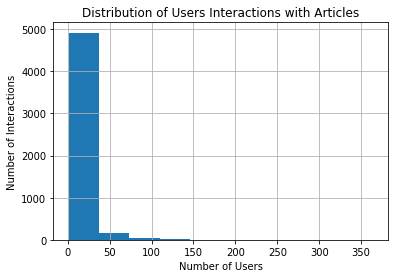

In [9]:
### Plotting the distribution of user interactions
data2 = df.groupby('email').count()['article_id']
plt.title('Distribution of Users Interactions with Articles')
plt.xlabel('Number of Users')
plt.ylabel('Number of Interactions')
data2.hist(bins=10)
plt.show()

In [10]:
### Checking the distribution
data2.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [11]:
### Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = data2.describe().loc['50%']

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = data2.max()

print(f'50% of individuals interact with {median_val} number of articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
### Finding and exploring duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

,article_id,doc_status,doc_body,doc_description,doc_full_name
365,50,Live,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning
692,221,Live,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...
761,398,Live,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...
970,577,Live,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index
971,232,Live,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...


In [13]:
### Checking the number of unique articles
df_content.nunique()

article_id         1051
doc_status            1
doc_body           1036
doc_description    1022
doc_full_name      1051
dtype: int64

***Obs:*** There are 5 duplicates in the dataframe

In [14]:
### Removing any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])

### Checking number duplicates after 
df_content[df_content.duplicated(subset=['article_id'])]

,article_id,doc_status,doc_body,doc_description,doc_full_name


***Obs:*** All duplicates have been removed

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
### Checking the first rows
df.head()

,article_id,email,title
0,1430.0,ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7,"using pixiedust for fast, flexible, and easier..."
1,1314.0,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b,healthcare python streaming application demo
2,1429.0,b96a4f2e92d8572034b1e9b28f9ac673765cd074,use deep learning for image classification
3,1338.0,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7,ml optimization using cognitive assistant
4,1276.0,f01220c46fc92c6e6b161b1849de11faacd7ccb2,deploy your python model as a restful api


In [16]:
### Doing a row count
df.count()

article_id    45993
email         45976
title         45993
dtype: int64

In [17]:
### Checking the number of unique article_id's
df.nunique()

article_id     714
email         5148
title          714
dtype: int64

In [18]:
### Doing a row count
df_content.head()

,article_id,doc_status,doc_body,doc_description,doc_full_name
0,0,Live,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...
1,1,Live,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...
2,2,Live,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)"
3,3,Live,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...
4,4,Live,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX


In [19]:
### Doint a row count
df_content.count()

article_id         1051
doc_status         1051
doc_body           1037
doc_description    1048
doc_full_name      1051
dtype: int64

In [20]:
### Checking the number of unique article_id's
df_content.nunique()

article_id         1051
doc_status            1
doc_body           1031
doc_description    1019
doc_full_name      1051
dtype: int64

In [21]:
### The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

### The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique()

### The number of unique users
unique_users = df['email'].nunique()

### The number of user-article interactions
user_article_interactions = df.shape[0]

print(f'The number of unique articles that have at least one interaction: {unique_articles}')
print(f'The number of unique articles on the IBM platform: {total_articles}')
print(f'The number of unique articles users: {unique_users}')
print(f'The number of user-article interactions: {user_article_interactions}')

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique articles users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [22]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = str(df['article_id'].value_counts().index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = df['article_id'].value_counts().iloc[0]


print(f'The most viewed article in the dataset as a string with one value following the decimal is : {most_viewed_article_id}')
print(f'The most viewed article in the dataset was viewed {max_views} times.')

The most viewed article in the dataset as a string with one value following the decimal is : 1429.0
The most viewed article in the dataset was viewed 937 times.


In [23]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [24]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [25]:
### Reordering the columns and checking the data
df = df[['user_id', 'article_id', 'title']]
df.head()

,user_id,article_id,title
0,1,1430.0,"using pixiedust for fast, flexible, and easier..."
1,2,1314.0,healthcare python streaming application demo
2,3,1429.0,use deep learning for image classification
3,4,1338.0,ml optimization using cognitive assistant
4,5,1276.0,deploy your python model as a restful api


In [26]:
### Doing a row count
df.count()

user_id       45993
article_id    45993
title         45993
dtype: int64

In [27]:
### Checking number of unique user id's
df['user_id'].nunique()

5149

In [28]:
### Checking unique number of article id's
df['article_id'].nunique()

714

In [29]:
### Checking unique number of titles
df['title'].nunique()

714

In [30]:
### Creating a dataframe containing title, number of interactions and article_id
stitle = df['title'].value_counts()
articles = pd.DataFrame({'title':stitle.index, 'Interactions':stitle.values})

### Selecting columns to be merged and dropping duplicates
df2 = df[['title', 'article_id']].drop_duplicates()

### Merging dataframes
top_articles = pd.merge(articles, df2, on='title', how='inner')

### Checking first rows
top_articles.head(5)

,title,Interactions,article_id
0,use deep learning for image classification,937,1429.0
1,insights from new york car accident reports,927,1330.0
2,visualize car data with brunel,671,1431.0
3,"use xgboost, scikit-learn & ibm watson machine...",643,1427.0
4,predicting churn with the spss random tree alg...,627,1364.0


In [31]:
### Getting a list with the top 5 most interacted articles
top_articles['title'].head(5).tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [32]:
### Getting a list with the top 5 article_id's
top_articles['article_id'].head(5).tolist()

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

### <a class="anchor" id="Rank">Answer</a>

In [33]:
def get_top_articles(n, df=top_articles):
    '''
    INPUT:
    n - (int) the number of top articles to return
    top_articles - (pandas dataframe) Creating a dataframe containing title, number of interactions and article_id 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    return top_articles['title'].head(n).tolist()

def get_top_article_ids(n, df=top_articles):
    '''
    INPUT:
    n - (int) the number of top articles to return
    top_articles - (pandas dataframe) Creating a dataframe containing title, number of interactions and article_id 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
 
    return top_articles['article_id'].head(n).tolist()

In [34]:
print(get_top_articles(10))
print()
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [35]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [36]:
### Creating a binary column 
df['interaction'] = 1
df.head()

,user_id,article_id,title,interaction
0,1,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,2,1314.0,healthcare python streaming application demo,1
2,3,1429.0,use deep learning for image classification,1
3,4,1338.0,ml optimization using cognitive assistant,1
4,5,1276.0,deploy your python model as a restful api,1


In [37]:
### Creating the matrix
df[['user_id', 'article_id', 'interaction']].pivot_table(index='user_id', columns='article_id').fillna(0).head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0   
user_id                   ...                                               
1             0.0    0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0   
2             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1441.0 1442.0 1443.0 1444.0  
user_id                                 
1             0.0    0.0    0.0    0.0  
2             0.0    0.0    0.0    0.0  
3             0.0    0.0    0.0    0.0  
4             0.0    0.0    0.0    0.0  
5             0.0    0.0    0.0    0.0  

[5 rows x 714 columns]

### <a class="anchor" id="User-User">Answer</a>

In [38]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    return df[['user_id', 'article_id', 'interaction']].pivot_table(index='user_id', columns='article_id').fillna(0)

In [39]:
user_item = create_user_item_matrix(df)
user_item.head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0   
user_id                   ...                                               
1             0.0    0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0   
2             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1441.0 1442.0 1443.0 1444.0  
user_id                                 
1             0.0    0.0    0.0    0.0  
2             0.0    0.0    0.0    0.0  
3             0.0    0.0    0.0    0.0  
4             0.0    0.0    0.0    0.0  
5             0.0    0.0    0.0    0.0  

[5 rows x 714 columns]

In [40]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [41]:
### Computing similarity of each user and sorting by similarity
similarity_between_users = user_item.dot(user_item.loc[1]).sort_values(ascending=False)
similarity_between_users.head()

user_id
1       36.0
3933    35.0
23      17.0
3782    17.0
203     15.0
dtype: float64

In [42]:
### Extracting indexes
similar_indexes = similarity_between_users.index
similar_indexes

Int64Index([   1, 3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201,
            ...
            2928, 2927, 2923, 2922, 2921, 2920, 2918, 2916, 2911, 2575],
           dtype='int64', name='user_id', length=5149)

In [43]:
### Dropping the user's own user_id
similar_indexes = similar_indexes.drop(1)
similar_indexes

Int64Index([3933,   23, 3782,  203, 4459,  131, 3870,   46, 4201, 5041,
            ...
            2928, 2927, 2923, 2922, 2921, 2920, 2918, 2916, 2911, 2575],
           dtype='int64', name='user_id', length=5148)

In [44]:
### Converting to list
similar_indexes = list(similar_indexes)

### Diplaying the 10 most similar users
similar_indexes[:10]

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]

### <a class="anchor" id="User-User">Answer</a>

In [45]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    similar_users = list(user_item.dot(user_item.loc[user_id]).sort_values(ascending=False).index.drop(user_id))
       
    # return a list of the users in order from most to least similar
    return similar_users

In [46]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [47]:
### Checking the data with the articles
df.head()

,user_id,article_id,title,interaction
0,1,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,2,1314.0,healthcare python streaming application demo,1
2,3,1429.0,use deep learning for image classification,1
3,4,1338.0,ml optimization using cognitive assistant,1
4,5,1276.0,deploy your python model as a restful api,1


In [48]:
### Getting the number of distinct articles
df['article_id'].nunique()

714

### Function get_article_names

In [49]:
### Creating a list of article id's
article_ids = list(df['article_id'].iloc[:5])
article_ids

[1430.0, 1314.0, 1429.0, 1338.0, 1276.0]

In [50]:
### Based on the article id's, getting the list of titles related to each article id
df[['title']][df.article_id.isin(article_ids)].drop_duplicates()['title'].values.tolist()

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo',
 'use deep learning for image classification',
 'ml optimization using cognitive assistant',
 'deploy your python model as a restful api']

### Function get_user_articles

In [51]:
### Checking all distinct articles user id 1 has interacted with
df2 = df[df.user_id == 1].drop_duplicates().sort_values(by='article_id')
df2.head()

,user_id,article_id,title,interaction
1710,1,43.0,deep learning with tensorflow course by big da...,1
1712,1,109.0,tensorflow quick tips,1
11083,1,151.0,jupyter notebook tutorial,1
20322,1,268.0,sector correlations shiny app,1
3839,1,310.0,time series prediction using recurrent neural ...,1


In [52]:
### Checking how many distinct articles user id 1 has interacted with
df2.shape[0]

36

In [53]:
### Getting the list of article id's
df2['article_id'].values.tolist()[:5]

[43.0, 109.0, 151.0, 268.0, 310.0]

In [54]:
### Getting the list of article names
df2['title'].values.tolist()[:5]

['deep learning with tensorflow course by big data university',
 'tensorflow quick tips',
 'jupyter notebook tutorial',
 'sector correlations shiny app',
 'time series prediction using recurrent neural networks (lstms)']

### Function user_user_recs

In [55]:
### Declaring the function for the sake of testing
def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id   - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids   - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    ### Getting the list of article id's and titles associated with a specific user
    df2 = df[df.user_id == user_id].drop_duplicates().sort_values(by='article_id')
    article_ids   = df2['article_id'].values.tolist()
    article_names = df2['title'].values.tolist() 
    
    # return the ids and names
    return article_ids, article_names

In [56]:
user_article_ids, _ = get_user_articles(1)
print(user_article_ids[:10])

[43.0, 109.0, 151.0, 268.0, 310.0, 329.0, 346.0, 390.0, 494.0, 525.0]


In [57]:
### Getting a list of similar users
similar_users = find_similar_users(1)
similar_users[:10]

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]

In [58]:
recs_ids = []

for user in similar_users:
    sim_article_ids, _ = get_user_articles(user)
        
    ### Getting a list of article ID's the user hasn't seen
    not_seen_ids = list(set(sim_article_ids) - (set(user_article_ids)))
        
    ### Adding article id's to the recommendations list
    recs_ids.extend(not_seen_ids)
        
    ### Updating the recommendations list with unique Id's
    recs_ids = list(set(recs_ids))
        
    if len(recs_ids) > 10:
        break

### Getting a list of recommended article id's
recs_ids[:10]

[1025.0, 2.0, 517.0, 12.0, 524.0, 14.0, 16.0, 26.0, 1051.0, 28.0]

### <a class="anchor" id="User-User">Answer</a>

In [59]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df          - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    ### Getting the list of names
    article_values = df[['title']][df.article_id.isin(article_ids)].drop_duplicates()['title'].values.tolist()
    
    # Return the article names associated with list of article ids
    return article_values  


def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id   - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids   - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    ### Getting the list of article id's and titles associated with a specific user
    df2 = df[df.user_id == user_id].drop_duplicates().sort_values(by='article_id')
    article_ids   = df2['article_id'].values.tolist()
    article_names = df2['title'].values.tolist() 
    
    # return the ids and names
    return article_ids, article_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m       - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs_ids - (list) a list of recommended article_ids for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    ### Getting article Id's the user has seen
    print("Getting article Id's the user has seen")
    user_article_ids, _ = get_user_articles(user_id)
    
    ### Getting the list of similar users 
    print('Getting the list of similar users')
    similar_users = find_similar_users(user_id)
    
    ### Getting all recommendations from each similar user
    print('Getting all recommendations from each similar user')
    recs_ids = []

    for user in similar_users:
        sim_article_ids, _ = get_user_articles(user)
        
        ### Getting a list of article ID's the user hasn't seen
        not_seen_ids = list(set(sim_article_ids) - (set(user_article_ids)))
        
        ### Adding article id's to the recommendations list
        recs_ids.extend(not_seen_ids)
        
        ### Updating the recommendations list with unique Id's
        recs_ids = list(set(recs_ids))
        
        if len(recs_ids) > m:
            break
    
    print()
    print("Printing recommended article id's:")
    # return your recommendations for this user_id
    return recs_ids[:m]

In [60]:
### Getting recommended article id's
recommendations_ids = user_user_recs(1, 10)
recommendations_ids

Getting article Id's the user has seen
Getting the list of similar users
Getting all recommendations from each similar user

Printing recommended article id's:


[1025.0, 2.0, 517.0, 12.0, 524.0, 14.0, 16.0, 26.0, 1051.0, 28.0]

In [61]:
### Getting recommended titles based on article id's
get_article_names(recommendations_ids) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'shaping data with ibm data refinery',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'data tidying in data science experience',
 'using machine learning to predict parking difficulty',
 'data science platforms are on the rise and ibm is leading the way',
 'a tensorflow regression model to predict house values']

In [62]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([232.0, 844.0, 1320.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

### Function get_top_sorted_users

In [63]:
### Checking the matrix
user_item.head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0   
user_id                   ...                                               
1             0.0    0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0   
2             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1441.0 1442.0 1443.0 1444.0  
user_id                                 
1             0.0    0.0    0.0    0.0  
2             0.0    0.0    0.0    0.0  
3             0.0    0.0    0.0    0.0  
4             0.0    0.0    0.0    0.0  
5             0.0    0.0    0.0    0.0  

[5 rows x 714 columns]

In [64]:
### Checking df
df.head()

,user_id,article_id,title,interaction
0,1,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,2,1314.0,healthcare python streaming application demo,1
2,3,1429.0,use deep learning for image classification,1
3,4,1338.0,ml optimization using cognitive assistant,1
4,5,1276.0,deploy your python model as a restful api,1


In [65]:
### Getting the number of rows
df.shape

(45993, 4)

In [66]:
### Getting the number of distinct users
n_users = df['user_id'].nunique()
n_users

5149

In [67]:
### Getting the number of distinct articles
n_articles = df['article_id'].nunique()
n_articles

714

In [68]:
### Calculating the number of articles each user interacted
user_int = df.groupby(['user_id'])['article_id'].count()
user_int.head()

user_id
1    47
2     6
3    82
4    45
5     5
Name: article_id, dtype: int64

In [69]:
### Creating a dataframe with the neighbor id and the number of interactions 
user_int_df = pd.DataFrame({'neighbor_id': user_int.index, 'n_interactions': user_int.values})
user_int_df.head()

,neighbor_id,n_interactions
0,1,47
1,2,6
2,3,82
3,4,45
4,5,5


In [70]:
### Calculating similarity among users
array_without_user = user_item.drop(1)
user_vector = np.array(user_item.loc[1]).reshape(-1, 1)

In [71]:
### Creating a dataframe with the neighbor id and the similarity
sim_df = pd.DataFrame({'neighbor_id': array_without_user.index,
                       'similarity': np.dot(array_without_user.values, user_vector).flatten()})
sim_df.head()

,neighbor_id,similarity
0,2,2.0
1,3,6.0
2,4,3.0
3,5,0.0
4,6,4.0


In [72]:
### Merging and sorting dataframes
neighbors_df = pd.merge(sim_df, user_int_df, on='neighbor_id', how='inner')
neighbors_df = neighbors_df.sort_values(['similarity', 'n_interactions'], ascending=False).head()
neighbors_df.head()

,neighbor_id,similarity,n_interactions
3931,3933,35.0,45
21,23,17.0,364
3780,3782,17.0,363
201,203,15.0,160
4457,4459,15.0,158


### Function user_user_recs_part2

In [73]:
### Declaring the function for the sake of testing
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id   - (int)
    df        - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
                 1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    user_int = df.groupby(['user_id'])['article_id'].count()
    user_int_df = pd.DataFrame({'neighbor_id': user_int.index, 'n_interactions': user_int.values})
    
    
    array_without_user = user_item.drop(user_id)
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    
    sim_df = pd.DataFrame({'neighbor_id': array_without_user.index,
                           'similarity': np.dot(array_without_user.values, user_vector).flatten()})
    
    
    neighbors_df = pd.merge(sim_df, user_int_df, on='neighbor_id', how='inner')
    neighbors_df = neighbors_df.sort_values(['similarity', 'n_interactions'], ascending=False)
    
    
    
    # Return the dataframe specified in the doc_string
    return neighbors_df

In [74]:
### Getting the user's neighbors - Run the functions first
neighbors_df = get_top_sorted_users(1)
neighbors_df.head(10)

,neighbor_id,similarity,n_interactions
3931,3933,35.0,45
21,23,17.0,364
3780,3782,17.0,363
201,203,15.0,160
4457,4459,15.0,158
129,131,14.0,145
3868,3870,14.0,144
44,46,13.0,63
4199,4201,13.0,61
47,49,12.0,147


In [75]:
### Getting a list with the top 10 neighbors
top_10_neighbors = neighbors_df['neighbor_id'].iloc[:10].tolist()
top_10_neighbors

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]

In [76]:
### Getting a list of recommended article id's
recs = []

for art_id in top_10_neighbors:
    recs.extend(df['article_id'][df.user_id == art_id].unique().tolist())
    recs = list(set(recs))
    
### Selecting the first 10 article id's    
recs = recs[:10]
recs

[1025.0, 2.0, 517.0, 8.0, 12.0, 525.0, 14.0, 524.0, 16.0, 528.0]

In [77]:
### Getting a list of recommended articles based on the recommended article id's
rec_names = df['title'][df.article_id.isin(recs)].unique().tolist()
rec_names

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 '10 tips on using jupyter notebook',
 'shaping data with ibm data refinery',
 'new shiny cheat sheet and video tutorial',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'data tidying in data science experience',
 'data science bowl 2017',
 'data science platforms are on the rise and ibm is leading the way']

### <a class="anchor" id="User-User">Answer</a>

In [78]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id   - (int)
    df        - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
                 1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    user_int = df.groupby(['user_id'])['article_id'].count()
    user_int_df = pd.DataFrame({'neighbor_id': user_int.index, 'n_interactions': user_int.values})
    
    
    array_without_user = user_item.drop(user_id)
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    
    sim_df = pd.DataFrame({'neighbor_id': array_without_user.index,
                           'similarity': np.dot(array_without_user.values, user_vector).flatten()})
    
    
    neighbors_df = pd.merge(sim_df, user_int_df, on='neighbor_id', how='inner')
    neighbors_df = neighbors_df.sort_values(['similarity', 'n_interactions'], ascending=False)
    
    
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    ### Getting the user's neighbors 
    neighbors_df = get_top_sorted_users(user_id)
    
    ### Getting a list with the top m neighbors
    top_m_neighbors = neighbors_df['neighbor_id'].iloc[:m].tolist()
    
    ### Getting a list of recommended article id's
    recs = []

    for art_id in top_m_neighbors:
        recs.extend(df['article_id'][df.user_id == art_id].unique().tolist())
        recs = list(set(recs))
    
    ### Selecting the first m article id's
    recs = recs[:m]
    
    ### Getting a list of recommended articles based on the recommended article id's
    rec_names = df['title'][df.article_id.isin(recs)].unique().tolist()  
    
    return recs, rec_names

In [79]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1024.0, 1035.0, 12.0, 14.0, 528.0, 1052.0, 1053.0, 29.0, 33.0, 34.0]

The top 10 recommendations for user 20 are the following article names:
['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'access db2 warehouse on cloud and db2 with python', 'access mysql with python', '10 tips on using jupyter notebook', 'using brunel in ipython/jupyter notebooks', 'experience iot with coursera', 'using deep learning to reconstruct high-resolution audio', 'machine learning for the enterprise.', 'top 10 machine learning use cases: part 1']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [80]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1
user1_most_sim =  get_top_sorted_users(1).iloc[0].loc['neighbor_id']
user1_most_sim

3933.0

In [81]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].loc['neighbor_id']
user131_10th_sim

242.0

In [82]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.


**The appropriate solution for a new user is to recommend the most popular articles across the user base.**

**Therefore, the function I would use as recommendation is get_top_articles_ids(10).**

**However, the recommendations might not be relevant to the user since it is a general recommendation. Unfortunately, we know nothing about the user's preferences.**


**We could use Knowledge-Based Recommendations as a way of coming around this issue. We could ask the user to provide some information about the types of articles they are interested in. With this informaion in hand, we could recommend him other articles.**


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [83]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [84]:
assert set(new_user_recs) == set([1314.0, 1429.0, 1293.0, 1427.0, 1162.0, 1364.0 , 1304.0, 1170.0, 1431.0, 1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [85]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [86]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [87]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [88]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [89]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

In [90]:
### Checking the shape of each matrix
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [91]:
### Checking if the matrixes contain null values
print(np.unique(np.isnan(u)))
print(np.unique(np.isnan(s)))
print(np.unique(np.isnan(vt)))

[False]
[False]
[False]


**This is different than the lesson because there are no null values in the dataset Therefore, SVD can be calculated.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

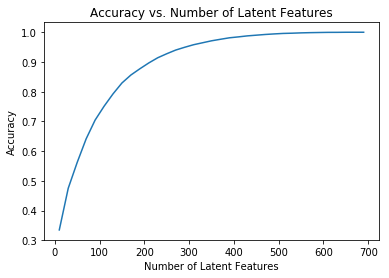

In [92]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [93]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                     (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                     (unique users for each row and unique articles for each column)
    train_idx      - all of the train user ids
    test_idx       - all of the test user ids
    train_arts_ids - all of the train article ids
    test_arts_ids  - all of the test article ids
    
    '''
    
    ### Creating train and test user-article matrixes
    user_item_train = create_user_item_matrix(df_train)
    user_item_test  = create_user_item_matrix(df_test)
    
    ### Creating a list of unique user id's for the training and testing set
    train_idx = list(set(user_item_train.index)) 
    test_idx  = list(set(user_item_test.index))
    
    ### Creating a list of unique article id's for the training set
    train_arts_ids = list(set(user_item_train.columns))
    train_arts_ids = [train_arts_ids[i][1] for i in range(len(train_arts_ids))]
    train_arts_ids.sort()
    
    ### Creating a list of unique article id's for the testing set
    test_arts_ids = list(set(user_item_test.columns))
    test_arts_ids = [test_arts_ids[i][1] for i in range(len(test_arts_ids))]
    test_arts_ids.sort()
    
    return user_item_train, user_item_test, train_idx, test_idx, train_arts_ids, test_arts_ids

In [94]:
### Calling the function
user_item_train, user_item_test, train_user_ids, test_user_ids, train_arts_ids, test_arts_ids = create_test_and_train_user_item(df_train, df_test)

In [95]:
### Checking the training data
user_item_train.head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
1                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3                  0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0   
user_id                   ...                                               
1             0.0    0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0   
2             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1441.0 1442.0 1443.0 1444.0  
user_id                                 
1             0.0    0.0    0.0    0.0  
2             0.0    0.0    0.0    0.0  
3             0.0    0.0    0.0    0.0  
4             0.0    0.0    0.0    0.0  
5             0.0    0.0    0.0    0.0  

[5 rows x 714 columns]

In [96]:
### Checking the testing data
user_item_test.head()

interaction                                                   \
article_id      0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0     
user_id                                                                   
2917               0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3024               0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3093               0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3193               0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3527               0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                          ...                                              \
article_id 16.0   18.0    ...   1432.0 1433.0 1434.0 1435.0 1436.0 1437.0   
user_id                   ...                                               
2917          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3024          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3093          0.0    0.0  ...      0.0    0.0    0.0    0.0    1.0    0.0   
3193          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   
3527          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0   

                                        
article_id 1439.0 1440.0 1441.0 1443.0  
user_id                                 
2917          0.0    0.0    0.0    0.0  
3024          0.0    0.0    0.0    0.0  
3093          0.0    0.0    0.0    0.0  
3193          0.0    0.0    0.0    0.0  
3527          0.0    0.0    0.0    0.0  

[5 rows x 574 columns]

In [97]:
### Checking unique train user id's
train_user_ids[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [98]:
### Checking unique test user id's
test_user_ids[:10]

[4204, 4231, 4274, 4293, 4487, 4488, 4489, 4490, 4491, 4492]

In [99]:
### Checking unique train article id's
train_arts_ids[:10]

[0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0]

In [100]:
### Checking unique test article id's
test_arts_ids[:10]

[0.0, 2.0, 4.0, 8.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0]

In [101]:
### Number of users we can make predictions for the test set
user_ids_match = list(set(train_user_ids) & set(test_user_ids))
user_ids_match.sort()
n_able_to_predict_users = len(user_ids_match)

print(f'Number of users: {n_able_to_predict_users}')

Number of users: 20


In [102]:
### Number of users in the test set are we not able to make predictions for because of the cold start problem
n_test_user_ids = len(test_user_ids)

print(f'Number of users: {n_test_user_ids - n_able_to_predict_users}')

Number of users: 662


In [103]:
### Number of articles can we make predictions for in the test set
arts_ids_match = list(set(train_arts_ids) & set(test_arts_ids))
arts_ids_match.sort()
n_able_to_predict_articles = len(arts_ids_match)


print(f'Number of articles: {n_able_to_predict_articles}')

Number of articles: 574


In [104]:
### Number of articles in the test set are we not able to make predictions for because of the cold start problem
n_test_article_ids = len(test_arts_ids)

print(f'Number of articles: {n_test_article_ids - n_able_to_predict_articles}')

Number of articles: 0


In [105]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [106]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [107]:
### Checking the shape of each matrix
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [108]:
### Creating the matrixes based on matching user id's and article id's
common_user_ids = user_item_train.index.isin(user_item_test.index)
common_art_ids = user_item_train.columns.isin(user_item_test.columns)


u_test, vt_test = u_train[common_user_ids, :], vt_train[:, common_art_ids]

In [109]:
### Checking the shape of the matrixes
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [110]:
### Creating the matrix whose predictions will be compared to
user_item_test_set = user_item_test.loc[user_ids_match, ]
user_item_test_set.shape

(20, 574)

In [112]:
### Computing and storing training and testing errors
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test  = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_pred  = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # compute error for training and testing prediction to the actual value
    diffs_train = np.subtract(user_item_train, user_item_train_pred)
    diffs_test = np.subtract(user_item_test_set, user_item_test_pred)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test  = np.sum(np.sum(np.abs(diffs_test)))
    
    # appending error values to the lists
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

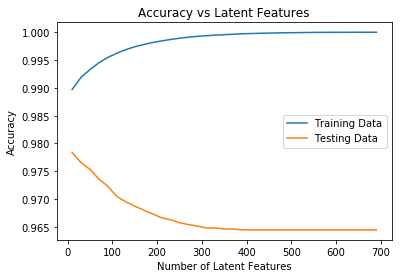

In [113]:
### Plotting Training and Testing accuracies
plt.plot(num_latent_feats,
         1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]),
         label='Training Data')

plt.plot(num_latent_feats,
         1 - np.array(sum_errs_test)/(user_item_test_set.shape[0]*user_item_test_set.shape[1]),
         label='Testing Data')

plt.legend()
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**It is clear that the model is overfitting as we increase the number of latent features. While the number of latent features is small (less than 50), the model seems robust.**

**However, as the number of latent features increases, so does the gap between training and testing accuracy. Moreover, we are working with a very small sample (20 users), so we need more data in order to develop a more accurate recommendation engine.**

**One optional approach is to use A/B testing to measure how effective our recommendation system is. We could separate users into two groups. One would use rank based recommendations, while the other would use random recommendations. Then, we could check how the number of views changed.**

**To finish, Cross Validation can be used to tune the model, determining the number of latent features needed to optimize the model's accuracy.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [114]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0